# Fundamental Analysis
This notebook plots various fundamental statistics of different stocks.  
These links were helpful:  
https://simply-python.com/2015/02/13/getting-historical-financial-statistics-of-stock-using-python/  
http://stackoverflow.com/questions/40139537/scrape-yahoo-finance-financial-ratios  
https://automatetheboringstuff.com/chapter11/  

## Todo
- Also need to make sure you're using stocks from the **same sector**, as different sectors can have different debt/equity standards, profit margins, etc.
- Then, just get that ML algorithm working baybee.

In [1]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint as pp
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import BMonthEnd
from pattern.web import URL
%matplotlib inline

In [2]:
tickers = pd.read_csv('csv/s&p500.csv',delimiter=",")
print tickers["Sector"].unique()
tickers.head()

['Industrials' 'Health Care' 'Information Technology'
 'Consumer Discretionary' 'Utilities' 'Financials' 'Materials'
 'Consumer Staples' 'Energy' 'Telecommunications Services']


,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,ABT,Abbott Laboratories,Health Care
2,ABBV,AbbVie,Health Care
3,ACN,Accenture plc,Information Technology
4,ATVI,Activision Blizzard,Information Technology


In [46]:
#scrapes financial data from Morningstar
def get_stock_financials(stock,year):
    path = "Fundamental_Analysis/"
    skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
    del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
    try:
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows, dtype='float')
    except:
        webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
        url = URL(webpage)
        f = open('%s%s_keyratios.csv'%(path, stock), 'wb') # save as test.gif
        f.write(url.download())
        f.close()
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows, dtype='float')
    d = d.transpose().reset_index()
    d = d.dropna(axis='columns', how='all')
    d.insert(0,'stock',stock)
    for dc in del_columns: #delete annoying repeated columns
        try:
            del d[dc]
        except:
            pass
    return d[d['index'].str.contains("%d"%year)]

def last_weekday_of_month(date):
    return pd.date_range(date, periods=1, freq='BM')

def get_frac_price_change(stock,date):
    last_current = last_weekday_of_month(date)
    ds = date.split('-')
    last_future = last_weekday_of_month('%d-%s'%(int(ds[0])+1, ds[1]))
    current_price = DataReader(stock, 'yahoo', last_current, last_current)['Adj Close'].values[0]
    future_price = DataReader(stock, 'yahoo', last_future, last_future)['Adj Close'].values[0]
    return (future_price - current_price)/current_price

## Get Data
Process data, could take a moment.

In [32]:
stocks = pd.read_csv('csv/s&p500.csv',delimiter=",")
year = 2014

#get X data and y data
cols = get_stock_financials(stocks["Symbol"][0],year).columns
X = pd.DataFrame(columns=cols)
y = []
for s in stocks["Symbol"]:
    try:
        _X = get_stock_financials(s,year)
        _y = get_frac_price_change(s,_X['index'].values[0])
        if _X.shape[1] > 1 and _y:
            X = X.append(_X)
            y.append(_y)
    except:
        print "could not process stock %s"%s
X = X.set_index('stock')
X = X.convert_objects(convert_numeric=True)

could not process stock AA
could not process stock BRK-B
could not process stock BF-B
could not process stock CSRA
could not process stock FTV
could not process stock HPE
could not process stock KHC
could not process stock PYPL
could not process stock QRVO
could not process stock UA
could not process stock WRK
could not process stock WLTW


In [5]:
#all available columns for analysis
#X.columns

In [55]:
X['Debt/Equity'] = pd.to_numeric(X['Debt/Equity'])
#X = X.convert_objects(convert_numeric=True)

## Process Data
Grab columns of interest to be used, replace NaN values, get training/test sets.

In [56]:
percentiles = ['Net Margin %','Gross Margin %','Operating Margin %','Return on Assets %', 'Payout Ratio % *',
               'Return on Invested Capital %','Return on Equity %','Free Cash Flow/Sales %']
ratios = ['Book Value Per Share * USD', 'Earnings Per Share USD','Free Cash Flow Per Share * USD', 'Debt/Equity',
         'Current Ratio','Dividends USD','EBT Margin','Quick Ratio']

columns = percentiles + ratios

In [57]:
XX = X[columns]

In [58]:
#replace NaN values with median of column if they represent <10% of values
for c in columns:
    frac_NaN = XX[c].isnull().sum()/float(len(XX))
    if frac_NaN > 0.1:
        del XX[c]
    else:
        XX[c] = pd.to_numeric(XX[c])
        XX[c].fillna(XX[c].median(), inplace=True)
    print c, frac_NaN

columns = XX.columns

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Net Margin % 0.0
Gross Margin % 0.105691056911
Operating Margin % 0.0
Return on Assets % 0.0
Payout Ratio % * 0.197154471545
Return on Invested Capital % 0.126016260163
Return on Equity % 0.0243902439024
Free Cash Flow/Sales % 0.0
Book Value Per Share * USD 0.0020325203252
Earnings Per Share USD 0.0
Free Cash Flow Per Share * USD 0.00406504065041
Debt/Equity 0.0772357723577
Current Ratio 0.103658536585
Dividends USD 0.170731707317
EBT Margin 0.0
Quick Ratio 0.103658536585


In [63]:
XX.head()

,Net Margin %,Operating Margin %,Return on Assets %,Return on Equity %,Free Cash Flow/Sales %,Book Value Per Share * USD,Earnings Per Share USD,Free Cash Flow Per Share * USD,Debt/Equity,EBT Margin
stock,,,,,,,,,,
MMM,15.57,22.4,15.29,32.38,16.13,25.46,7.49,7.30,0.52,22.08
ABT,11.28,12.8,5.42,9.78,12.83,15.18,1.49,1.93,0.16,12.44
ABBV,8.89,17.1,6.25,56.91,14.71,2.92,1.10,2.96,6.06,11.87
ACN,9.23,13.5,16.91,55.02,9.93,8.53,4.52,4.00,0.67,13.48
ATVI,18.94,26.8,5.81,12.05,26.88,9.69,1.13,1.19,0.60,22.25


In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.33, random_state=42)

## Machine Learning tyme

In [74]:
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

### Best params so far:
-0.111054839795
{'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 0.1}

In [75]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
model = xgb.XGBClassifier()
n_cv = 3    #use 3 since dataset is kind of small
param_grid={
    'learning_rate': [0.1,0.01],
    'max_depth': [4,8,12,20],
    'min_child_weight': [0.1,1,10,100],
    'n_estimators':[1000],
}
grid = GridSearchCV(model, param_grid=param_grid, cv=n_cv, scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

-0.111054839795
{'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 0.1}


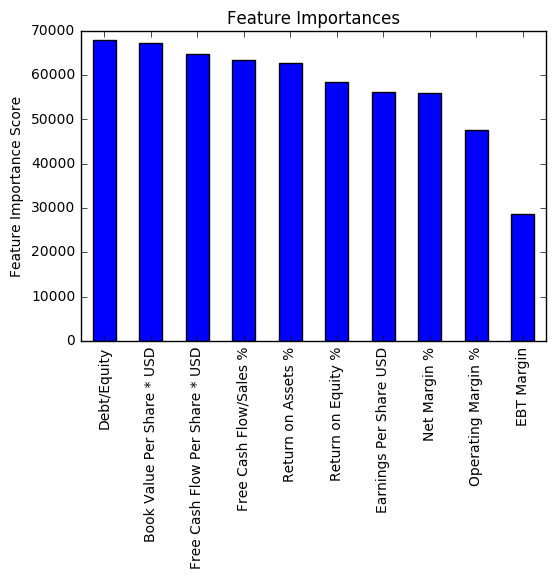

In [77]:
model = grid.best_estimator_
feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [81]:
y_test_predict = model.predict(X_test)

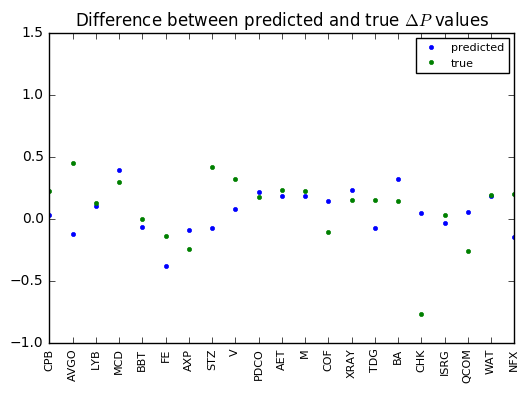

In [99]:
plt.plot(y_test_predict, '.', label='predicted')
plt.plot(y_test, '.', label='true')
plt.legend(fontsize=8, numpoints=1)
plt.xticks(range(len(y_test)), X_test.index, rotation='vertical', fontsize=8)
plt.xlim([0,20])
plt.title('Difference between predicted and true $\Delta P$ values');

# Extra

In [38]:
#s = "AA"
#data = get_stock_financials(s,2014)
#start = data['index'].values[0]
#get_frac_price_change(s,start)

#a= get_stock_price_change("ACN",start)
#print a

In [24]:
stock = "AEM"
webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
url = URL(webpage)
f = open('Fundamental_Analysis/%s_keyratios.csv'%stock, 'wb') # save as test.gif
f.write(url.download())
f.close()